### Data and imports

In [10]:
import numpy as np
import yfinance as yf # to get our data


from sklearn.preprocessing import MinMaxScaler # to normalize our classes
from sklearn.model_selection import train_test_split # from tutorial code
from sklearn.metrics import accuracy_score, confusion_matrix # needed for plotting


import matplotlib.pyplot as plt

import pandas as pd

#### Get Data from Yahoo Finance
We are using S&P 500 index as our training and testing data

In [ ]:
dfs = {}  # Dictionary to store data for each ticker

data = yf.Ticker('^GSPC')
hist = data.history(period="max")
print(f'Name: {data.info["shortName"]}')
print(f'Start date: {hist.index.min()}') 
print(f'End date: {hist.index.max()}')
dfs['^GSPC'] = hist


Name: S&P 500
Start date: 1927-12-30 00:00:00-05:00
End date: 2024-11-29 00:00:00-05:00


Let us see the data in the graph

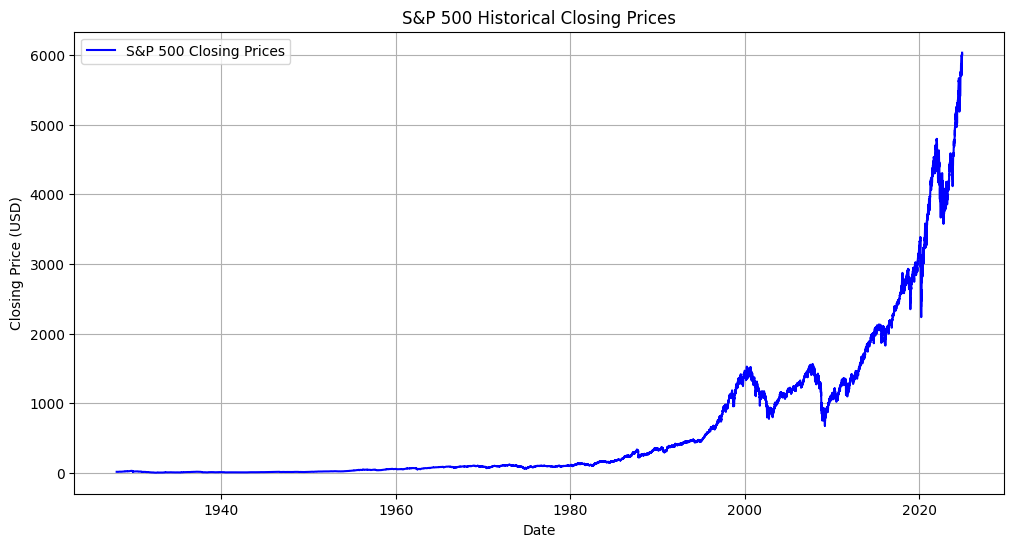

In [22]:
# Extract S&P 500 data
sp500_data = dfs['^GSPC']

# Extract and clean closing prices
closing_prices = sp500_data['Close'].dropna()

# Convert index and values to numpy arrays for robust plotting
x = closing_prices.index.to_numpy()
y = closing_prices.to_numpy()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(x, y, label='S&P 500 Closing Prices', color='blue')
plt.title("S&P 500 Historical Closing Prices")
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.legend()
plt.grid(True)
plt.show()